<a href="https://colab.research.google.com/github/amanjaiswal777/ICCIT-Workshop/blob/main/02_movie_recommendations_user_cf_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Movie Recommendations — User-Based Collaborative Filtering
This notebook builds an end-to-end user-based collaborative filtering recommender using synthetic data. It includes dataset generation, similarity computation, visualization, prediction, evaluation, and an interactive recommendation function.

## 🎯 Learning Objectives
- Generate a sparse user-item rating matrix
- Compute cosine similarity between users
- Visualize similarity matrices and user networks
- Implement user-based collaborative filtering (neighbor-based)
- Evaluate recommendations with RMSE and Top-N checks
- Discuss real-world differences (Netflix vs Spotify)


## 📦 Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set_theme(style="whitegrid")
rng = np.random.default_rng(42)


## 🔬 1) Synthetic Ratings Data Generation
We simulate latent user/item factors then generate noisy ratings and introduce realistic sparsity (~85% missing).

In [2]:
# Parameters
n_users = 250
n_items = 180
latent_k = 6

# Latent factors
U = rng.normal(0, 1, (n_users, latent_k))
V = rng.normal(0, 1, (n_items, latent_k))

# Base ratings from latent factors
base_ratings = 3.0 + (U @ V.T) / 2.0  # center around 3.0, scaled

# Add noise and clip to 0.5-5.0
ratings = base_ratings + rng.normal(0, 0.6, base_ratings.shape)
ratings = np.clip(ratings, 0.5, 5.0)

# Introduce sparsity: only 15% observed
mask = rng.uniform(0, 1, ratings.shape) < 0.15
R_obs = np.where(mask, ratings, np.nan)

# Create DataFrame
users = [f"U{i:03d}" for i in range(n_users)]
items = [f"M{i:03d}" for i in range(n_items)]
R = pd.DataFrame(R_obs, index=users, columns=items)

print('Users:', n_users, 'Items:', n_items)
print('Observed fraction:', np.isfinite(R.values).mean().round(3))
R.iloc[:6, :8].head()


Users: 250 Items: 180
Observed fraction: 0.148


M000  M001  M002  M003      M004  M005      M006  M007
U000   NaN   NaN   NaN   NaN       NaN   NaN       NaN   NaN
U001   NaN   NaN   NaN   NaN       NaN   NaN  1.794861   NaN
U002   NaN   NaN   NaN   NaN  3.178635   NaN       NaN   NaN
U003   NaN   NaN   NaN   NaN       NaN   NaN       NaN   NaN
U004   NaN   NaN   NaN   NaN       NaN   NaN       NaN   NaN

## 📊 2) Exploratory Data Analysis

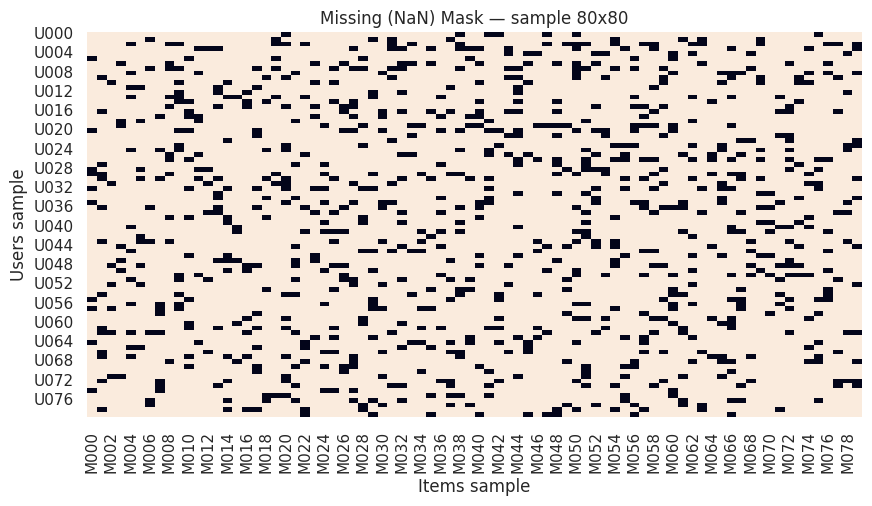

In [3]:
# Visualize sparsity pattern (sample)
plt.figure(figsize=(10,5))
sns.heatmap(pd.isna(R).iloc[:80, :80], cbar=False)
plt.title('Missing (NaN) Mask — sample 80x80')
plt.xlabel('Items sample')
plt.ylabel('Users sample')
plt.show()

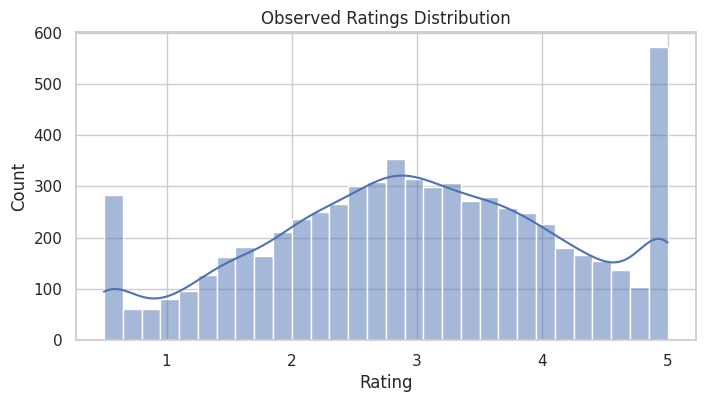

In [4]:
# Distribution of observed ratings
plt.figure(figsize=(8,4))
sns.histplot(R.stack(), bins=30, kde=True)
plt.title('Observed Ratings Distribution')
plt.xlabel('Rating')
plt.show()

## 🧮 3) Compute User Similarity (Cosine)

In [5]:
# Fill missing values with user mean for similarity computation
R_filled = R.apply(lambda row: row.fillna(row.mean()), axis=1)

# Cosine similarity between users
S = pd.DataFrame(cosine_similarity(R_filled), index=users, columns=users)
S.iloc[:6, :6]

U000      U001      U002      U003      U004      U005
U000  1.000000  0.982891  0.986150  0.982400  0.992341  0.978919
U001  0.982891  1.000000  0.984484  0.984484  0.988539  0.980477
U002  0.986150  0.984484  1.000000  0.983099  0.989005  0.978646
U003  0.982400  0.984484  0.983099  1.000000  0.987787  0.978443
U004  0.992341  0.988539  0.989005  0.987787  1.000000  0.984567
U005  0.978919  0.980477  0.978646  0.978443  0.984567  1.000000

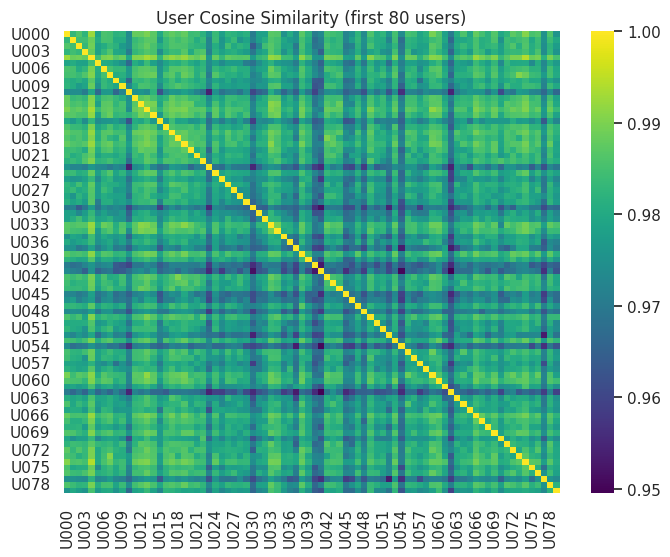

In [6]:
# Visualize a block of the similarity matrix
plt.figure(figsize=(8,6))
sns.heatmap(S.iloc[:80, :80], cmap='viridis')
plt.title('User Cosine Similarity (first 80 users)')
plt.show()

## 🌐 4) User Similarity Network Visualization

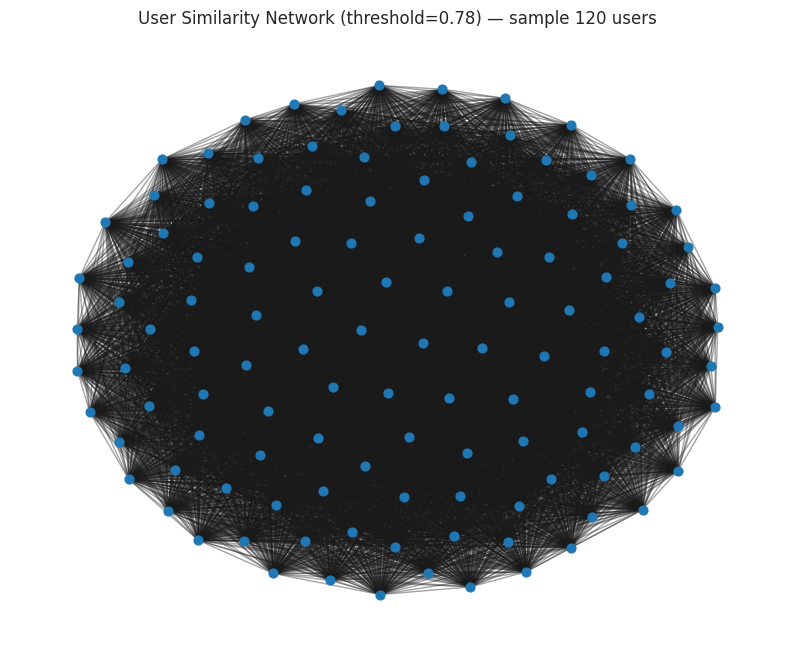

In [7]:
# Build graph connecting users with similarity > threshold
threshold = 0.78
G = nx.Graph()
sample_users = users[:120]  # visualize subset

for u in sample_users:
    sims = S.loc[u, sample_users].drop(u)
    for v, sim in sims.items():
        if sim > threshold:
            G.add_edge(u, v, weight=float(sim))

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.title(f'User Similarity Network (threshold={threshold}) — sample {len(sample_users)} users')
plt.axis('off')
plt.show()

## 🧩 5) User-Based Collaborative Filtering — Prediction Function
We implement a neighborhood-based predictor using top-k similar users and mean-centering.

In [8]:
def predict_user_based(R, S, k=20):
    """Predict full rating matrix using user-based CF with top-k neighbors.
    R: DataFrame with NaNs for missing
    S: similarity DataFrame (users x users)
    k: number of neighbors
    Returns: DataFrame of predictions
    """
    R_mean = R.mean(axis=1)
    R_demeaned = R.sub(R_mean, axis=0)
    R_pred = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)

    for u in R.index:
        # top-k neighbors excluding self
        neighbors = S.loc[u].drop(u).nlargest(k).index
        sims = S.loc[u, neighbors].values
        # weighted sum (handle NaNs by skipna)
        num = (R_demeaned.loc[neighbors].multiply(sims[:, None], axis=0)).sum(axis=0, skipna=True)
        den = np.abs(sims).sum()
        # if den==0 fallback to user mean
        pred = R_mean[u] + num / (den + 1e-8)
        R_pred.loc[u] = pred
    return R_pred

# Quick run on our full matrix (may take a little time)
R_pred = predict_user_based(R, S, k=20)
R_pred.iloc[:5, :5]


M000      M001      M002      M003      M004
U000  3.501973  3.586272  3.409131  3.487201  3.531827
U001  2.613557  2.823689  2.460109  2.635431  2.509273
U002  3.109764  3.140571  2.985995  3.130774  2.939827
U003  2.664335  2.712300  2.583524  2.667716  2.560054
U004  3.420266  3.500252  3.246676  3.391506  3.269957

## 🧪 6) Evaluation — Holdout RMSE
We create a test set by hiding a subset of observed ratings and compute RMSE.

In [9]:
# Build train/test by masking a subset of observed entries
obs_idx = np.argwhere(~np.isnan(R.values))
n_test = min(3000, len(obs_idx)//5)
test_sel = rng.choice(len(obs_idx), size=n_test, replace=False)
test_pairs = obs_idx[test_sel]

R_train = R.copy()
test_truth = []
for u_i, m_i in test_pairs:
    test_truth.append(R_train.iat[u_i, m_i])
    R_train.iat[u_i, m_i] = np.nan
test_truth = np.array(test_truth)

# Recompute similarity on train (fill with user means)
R_filled_train = R_train.apply(lambda row: row.fillna(row.mean()), axis=1)
S_train = pd.DataFrame(cosine_similarity(R_filled_train), index=users, columns=users)

R_pred_train = predict_user_based(R_train, S_train, k=20)

# Evaluate on test pairs
test_preds = []
for (u_i, m_i) in test_pairs:
    u = users[u_i]; m = items[m_i]
    test_preds.append(R_pred_train.at[u, m])
test_preds = np.array(test_preds)

rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
print('Holdout RMSE:', round(rmse, 4))

Holdout RMSE: 1.2179


## 🔎 7) Interactive: Get Top-N Recommendations for a User

In [10]:
def recommend_for_user(user_id, R, R_pred, top_n=10, exclude_seen=True):
    """Return top-N item recommendations for a given user using predicted ratings."""
    if user_id not in R.index:
        raise ValueError('Unknown user')
    preds = R_pred.loc[user_id].sort_values(ascending=False)
    if exclude_seen:
        seen = R.loc[user_id].dropna().index
        preds = preds.drop(labels=seen, errors='ignore')
    return preds.head(top_n)

# Example: Recommend for user U000
user = users[0]
top10 = recommend_for_user(user, R, R_pred, top_n=10)
print('Top-10 recommendations for', user)
display(top10)

Top-10 recommendations for U000


M037    3.645421
M029    3.603837
M129    3.597268
M001    3.586272
M046    3.582730
M164    3.574039
M013    3.570168
M051    3.560674
M110    3.560348
M058    3.558037
Name: U000, dtype: float64

## 🔬 8) Item-Based CF (Optional) — Sketch Implementation

In [11]:
# Compute item-item similarity (fill NaNs with item mean)
R_filled_item = R.apply(lambda col: col.fillna(col.mean()), axis=0)
S_item = pd.DataFrame(cosine_similarity(R_filled_item.T), index=items, columns=items)

def predict_item_based(R, S_item, k=20):
    R_pred = pd.DataFrame(index=R.index, columns=R.columns, dtype=float)
    for i in R.columns:
        sims = S_item.loc[i].drop(i).nlargest(k)
        neighbors = sims.index
        sim_vals = sims.values
        num = (R[neighbors].multiply(sim_vals, axis=1)).sum(axis=1, skipna=True)
        den = np.abs(sim_vals).sum() + 1e-8
        R_pred[i] = num / den
    return R_pred

R_pred_item = predict_item_based(R, S_item, k=20)
R_pred_item.iloc[:4, :6]

M000      M001      M002      M003      M004      M005
U000  0.496508  0.884896  0.527498  0.302493  0.799206  0.527567
U001  0.513799  0.634594  0.442235  0.576135  0.418180  0.489443
U002  0.461174  0.794933  0.486447  0.505504  0.630244  0.649124
U003  0.294334  0.401885  0.596537  0.670330  0.294526  0.916720

## 📈 9) Top-N Evaluation (Precision@K style)
We compute how many of the held-out test items appear in the Top-N recommendations for each user.

In [12]:
# Build a small test set per user: hide one rating per some users
# (reuse test_pairs from earlier; convert to per-user ground truth)
from collections import defaultdict
user_holdouts = defaultdict(list)
for (u_i, m_i), val in zip(test_pairs, test_truth):
    user_holdouts[users[u_i]].append((items[m_i], val))

# Evaluate Precision@10
def precision_at_k(R_train, R_pred, user_holdouts, k=10):
    hits = 0
    total = 0
    for u, holdouts in user_holdouts.items():
        preds = recommend_for_user(u, R_train, R_pred, top_n=k)
        pred_items = set(preds.index)
        for (item, true_val) in holdouts:
            total += 1
            if item in pred_items:
                hits += 1
    return hits / total if total>0 else np.nan

prec10 = precision_at_k(R_train, R_pred_train, user_holdouts, k=10)
print('Precision@10 (holdout):', round(prec10,4))

Precision@10 (holdout): 0.0608


## 🧾 10) Netflix vs Spotify — Practical Differences
- **Netflix** (movies/TV): Item catalog changes slowly; user tastes have temporal shifts; strong item metadata and sessions.
- **Spotify** (music): Catalog is huge, listen events are abundant; short-term recency and session-based recommendations matter.

Discuss how sparsity, feedback types (explicit ratings vs implicit plays), and evaluation metrics differ.

## 🎯 Assignment
1. Try different values of `k` in the user-based CF and observe RMSE and Precision@10.
2. Implement mean-centering for items (item bias) in predictions.
3. Swap to item-based CF and compare results.
4. (Advanced) Implement a simple matrix factorization (SVD) baseline and compare RMSE.

Write your answers/codes below.

In [13]:
# 🚀 Your experiments here
# Example: re-run predict_user_based with k=5, k=50 and compare.


## ✅ Assignment Solutions (Reference) — Hidden
Below are suggested solution snippets. Uncomment to run.

In [14]:
# --- SOLUTION EXAMPLES ---
# 1) Try k variation:
# for k in [5, 10, 20, 50]:
#     R_pred_k = predict_user_based(R_train, S_train, k=k)
#     test_preds_k = []
#     for (u_i, m_i) in test_pairs:
#         u = users[u_i]; m = items[m_i]
#         test_preds_k.append(R_pred_k.at[u, m])
#     rmse_k = np.sqrt(mean_squared_error(test_truth, np.array(test_preds_k)))
#     print('k=', k, 'RMSE=', round(rmse_k,4))
#
# 2) Item-based compare (already computed above as R_pred_item):
# test_preds_item = []
# for (u_i, m_i) in test_pairs:
#     u = users[u_i]; m = items[m_i]
#     test_preds_item.append(R_pred_item.at[u, m])
# print('Item-based RMSE=', round(np.sqrt(mean_squared_error(test_truth, np.array(test_preds_item))),4))
#
# 3) Quick SVD baseline using numpy (very simple):
# from numpy.linalg import svd
# R_filled_for_svd = R.fillna(R.mean().mean()).values
# U_s, s_s, Vt_s = svd(R_filled_for_svd, full_matrices=False)
# k_svd = 20
# S_mat = np.diag(s_s[:k_svd])
# U_k = U_s[:, :k_svd] @ S_mat
# V_k = Vt_s[:k_svd, :]
# R_svd_pred = pd.DataFrame(U_k @ V_k, index=users, columns=items)
# test_preds_svd = []
# for (u_i, m_i) in test_pairs:
#     test_preds_svd.append(R_svd_pred.iat[u_i, m_i])
# print('SVD RMSE:', round(np.sqrt(mean_squared_error(test_truth, np.array(test_preds_svd))),4))


In [15]:
# 🎬 3D Visualizations for Movie Recommendations & Collaborative Filtering
# Add these stunning 3D visualizations to your collaborative filtering notebook!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import plotly.figure_factory as ff

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. 🌟 3D USER-ITEM RATING SPACE VISUALIZATION
# ============================================================================

def plot_3d_rating_space(R, n_components=3, sample_users=50, sample_items=50):
    """
    Create 3D visualization of user-item rating space using dimensionality reduction
    """
    # Sample data for visualization
    R_sample = R.iloc[:sample_users, :sample_items]

    # Fill NaN values with user means for PCA
    R_filled = R_sample.apply(lambda row: row.fillna(row.mean()), axis=1)
    R_filled = R_filled.fillna(0)  # Handle any remaining NaNs

    # Apply PCA to reduce to 3D
    pca = PCA(n_components=n_components)
    user_coords_3d = pca.fit_transform(R_filled)

    # Create 3D scatter plot
    fig = plt.figure(figsize=(15, 12))

    # Plot 1: 3D User Space
    ax1 = fig.add_subplot(221, projection='3d')

    # Color users by their average rating
    user_avg_ratings = R_filled.mean(axis=1)
    scatter = ax1.scatter(user_coords_3d[:, 0], user_coords_3d[:, 1], user_coords_3d[:, 2],
                         c=user_avg_ratings, cmap='viridis', s=60, alpha=0.7)

    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
    ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} var)')
    ax1.set_title('3D User Space (PCA)\nColored by Avg Rating')
    plt.colorbar(scatter, ax=ax1, shrink=0.5, label='Avg Rating')

    # Plot 2: 3D Item Space
    ax2 = fig.add_subplot(222, projection='3d')

    # Apply PCA to items (transpose)
    pca_items = PCA(n_components=n_components)
    item_coords_3d = pca_items.fit_transform(R_filled.T)

    # Color items by their average rating
    item_avg_ratings = R_filled.mean(axis=0)
    scatter2 = ax2.scatter(item_coords_3d[:, 0], item_coords_3d[:, 1], item_coords_3d[:, 2],
                          c=item_avg_ratings, cmap='plasma', s=60, alpha=0.7)

    ax2.set_xlabel(f'PC1 ({pca_items.explained_variance_ratio_[0]:.2%} var)')
    ax2.set_ylabel(f'PC2 ({pca_items.explained_variance_ratio_[1]:.2%} var)')
    ax2.set_zlabel(f'PC3 ({pca_items.explained_variance_ratio_[2]:.2%} var)')
    ax2.set_title('3D Item Space (PCA)\nColored by Avg Rating')
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Avg Rating')

    # Plot 3: Biplot - Users and Items together
    ax3 = fig.add_subplot(223, projection='3d')

    # Scale item coordinates to user space
    item_coords_scaled = item_coords_3d * 0.5

    ax3.scatter(user_coords_3d[:, 0], user_coords_3d[:, 1], user_coords_3d[:, 2],
               c='blue', alpha=0.6, s=40, label='Users')
    ax3.scatter(item_coords_scaled[:, 0], item_coords_scaled[:, 1], item_coords_scaled[:, 2],
               c='red', alpha=0.6, s=40, marker='^', label='Items')

    ax3.set_xlabel('First Component')
    ax3.set_ylabel('Second Component')
    ax3.set_zlabel('Third Component')
    ax3.set_title('3D User-Item Biplot')
    ax3.legend()

    # Plot 4: t-SNE 3D embedding
    ax4 = fig.add_subplot(224, projection='3d')

    # Apply t-SNE for non-linear embedding
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(30, len(R_filled)-1))
    user_tsne_3d = tsne.fit_transform(R_filled)

    scatter4 = ax4.scatter(user_tsne_3d[:, 0], user_tsne_3d[:, 1], user_tsne_3d[:, 2],
                          c=user_avg_ratings, cmap='coolwarm', s=60, alpha=0.7)

    ax4.set_xlabel('t-SNE 1')
    ax4.set_ylabel('t-SNE 2')
    ax4.set_zlabel('t-SNE 3')
    ax4.set_title('3D t-SNE User Embedding\nNon-linear clusters')
    plt.colorbar(scatter4, ax=ax4, shrink=0.5, label='Avg Rating')

    plt.tight_layout()
    plt.show()

    return user_coords_3d, item_coords_3d, pca.explained_variance_ratio_

# ============================================================================
# 2. 🕸️ INTERACTIVE 3D SIMILARITY NETWORK
# ============================================================================

def create_interactive_similarity_network(S, threshold=0.75, sample_size=100):
    """
    Create interactive 3D network showing user similarity relationships
    """
    # Sample users for visualization
    users_sample = S.index[:sample_size]
    S_sample = S.loc[users_sample, users_sample]

    # Create network graph
    G = nx.Graph()

    # Add edges for similarities above threshold
    edges = []
    edge_weights = []
    for i, user1 in enumerate(users_sample):
        for j, user2 in enumerate(users_sample):
            if i < j and S_sample.loc[user1, user2] > threshold:
                G.add_edge(user1, user2, weight=S_sample.loc[user1, user2])
                edges.append((i, j))
                edge_weights.append(S_sample.loc[user1, user2])

    # Get 3D layout
    pos_3d = nx.spring_layout(G, dim=3, seed=42)

    # Extract coordinates
    x_nodes = [pos_3d[node][0] for node in G.nodes()]
    y_nodes = [pos_3d[node][1] for node in G.nodes()]
    z_nodes = [pos_3d[node][2] for node in G.nodes()]

    # Create edge traces
    edge_x, edge_y, edge_z = [], [], []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    # Create the plot
    fig = go.Figure()

    # Add edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgba(125,125,125,0.5)', width=2),
        hoverinfo='none',
        name='Similarity Links'
    ))

    # Add nodes
    node_colors = [len(list(G.neighbors(node))) for node in G.nodes()]  # Color by degree

    fig.add_trace(go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers',
        marker=dict(
            size=8,
            color=node_colors,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Node Degree"),
            line=dict(width=2, color='black')
        ),
        text=list(G.nodes()),
        hovertemplate='<b>%{text}</b><br>Connections: %{marker.color}<extra></extra>',
        name='Users'
    ))

    fig.update_layout(
        title=f'Interactive 3D User Similarity Network<br>Threshold: {threshold}, Nodes: {len(G.nodes())}, Edges: {len(G.edges())}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            bgcolor='rgba(0,0,0,0.1)'
        ),
        showlegend=True,
        height=700
    )

    fig.show()

    return G

# ============================================================================
# 3. 🎯 3D PREDICTION ACCURACY LANDSCAPE
# ============================================================================

def plot_3d_prediction_landscape(R, R_pred, sample_users=50, sample_items=50):
    """
    Visualize prediction accuracy in 3D space
    """
    # Sample data
    R_sample = R.iloc[:sample_users, :sample_items]
    R_pred_sample = R_pred.iloc[:sample_users, :sample_items]

    # Calculate errors where we have actual ratings
    mask = ~np.isnan(R_sample.values)
    errors = np.where(mask, np.abs(R_sample.values - R_pred_sample.values), np.nan)

    # Create meshgrid for surface plot
    x = np.arange(sample_items)
    y = np.arange(sample_users)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(18, 6))

    # Plot 1: 3D Error Surface
    ax1 = fig.add_subplot(131, projection='3d')

    # Create surface where we have data
    Z_errors = errors.copy()
    Z_errors[np.isnan(Z_errors)] = 0  # Set missing to 0 for visualization

    surf1 = ax1.plot_surface(X, Y, Z_errors, cmap='Reds', alpha=0.7)
    ax1.set_xlabel('Items')
    ax1.set_ylabel('Users')
    ax1.set_zlabel('Prediction Error')
    ax1.set_title('3D Prediction Error Landscape')
    plt.colorbar(surf1, ax=ax1, shrink=0.5)

    # Plot 2: 3D Actual Ratings Surface
    ax2 = fig.add_subplot(132, projection='3d')

    Z_actual = R_sample.values.copy()
    Z_actual[np.isnan(Z_actual)] = 0

    surf2 = ax2.plot_surface(X, Y, Z_actual, cmap='Blues', alpha=0.7)
    ax2.set_xlabel('Items')
    ax2.set_ylabel('Users')
    ax2.set_zlabel('Actual Rating')
    ax2.set_title('3D Actual Ratings Surface')
    plt.colorbar(surf2, ax=ax2, shrink=0.5)

    # Plot 3: 3D Predicted Ratings Surface
    ax3 = fig.add_subplot(133, projection='3d')

    Z_pred = R_pred_sample.values

    surf3 = ax3.plot_surface(X, Y, Z_pred, cmap='Greens', alpha=0.7)
    ax3.set_xlabel('Items')
    ax3.set_ylabel('Users')
    ax3.set_zlabel('Predicted Rating')
    ax3.set_title('3D Predicted Ratings Surface')
    plt.colorbar(surf3, ax=ax3, shrink=0.5)

    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. 🌈 INTERACTIVE 3D RATING DISTRIBUTION
# ============================================================================

def create_interactive_rating_distribution(R):
    """
    Create interactive 3D histogram of rating distributions
    """
    # Get all observed ratings
    ratings = R.stack().dropna()

    # Create 3D histogram data
    hist, xedges, yedges = np.histogram2d(
        ratings.index.get_level_values(0).map(lambda x: int(x[1:])),  # User index
        ratings.values,  # Rating values
        bins=[50, 20]
    )

    # Create meshgrid
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)

    dx = np.diff(xedges)[0] * np.ones_like(xpos)
    dy = np.diff(yedges)[0] * np.ones_like(ypos)
    dz = hist.T.flatten()

    # Create interactive 3D bar plot
    fig = go.Figure(data=[go.Mesh3d(
        x=xpos, y=ypos, z=zpos,
        i=np.arange(len(xpos)), j=np.arange(len(xpos)), k=np.arange(len(xpos)),
        intensity=dz,
        colorscale='Viridis',
        showscale=True
    )])

    # Alternative: Use scatter plot for better performance
    fig = go.Figure()

    # Sample ratings for visualization
    ratings_sample = ratings.sample(min(5000, len(ratings)), random_state=42)
    user_indices = ratings_sample.index.get_level_values(0).map(lambda x: int(x[1:]))

    fig.add_trace(go.Scatter3d(
        x=user_indices,
        y=ratings_sample.values,
        z=np.random.normal(0, 0.1, len(ratings_sample)),  # Add jitter for 3D effect
        mode='markers',
        marker=dict(
            size=4,
            color=ratings_sample.values,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Rating"),
            opacity=0.6
        ),
        text=[f'User: {u}<br>Rating: {r:.1f}' for u, r in zip(user_indices, ratings_sample.values)],
        hovertemplate='%{text}<extra></extra>',
        name='Ratings'
    ))

    fig.update_layout(
        title='Interactive 3D Rating Distribution',
        scene=dict(
            xaxis_title='User Index',
            yaxis_title='Rating Value',
            zaxis_title='Density',
            bgcolor='rgba(0,0,0,0.1)'
        ),
        height=600
    )

    fig.show()

# ============================================================================
# 5. 🔮 3D COLLABORATIVE FILTERING ALGORITHM VISUALIZATION
# ============================================================================

def visualize_cf_algorithm_3d(R, S, user_id, item_id, k=10):
    """
    Visualize how collaborative filtering works in 3D space
    """
    if user_id not in R.index or item_id not in R.columns:
        print("Invalid user or item ID")
        return

    # Get top-k similar users
    similar_users = S.loc[user_id].drop(user_id).nlargest(k).index
    similarities = S.loc[user_id, similar_users].values

    # Get ratings of similar users for the target item
    neighbor_ratings = []
    neighbor_sims = []
    valid_neighbors = []

    for i, neighbor in enumerate(similar_users):
        if not np.isnan(R.loc[neighbor, item_id]):
            neighbor_ratings.append(R.loc[neighbor, item_id])
            neighbor_sims.append(similarities[i])
            valid_neighbors.append(neighbor)

    if not neighbor_ratings:
        print("No valid neighbors found")
        return

    # Create 3D visualization
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: 3D Neighbor Space
    ax1 = fig.add_subplot(221, projection='3d')

    # Create coordinates for visualization
    x_coords = range(len(valid_neighbors))
    y_coords = neighbor_ratings
    z_coords = neighbor_sims

    # Color by similarity
    colors = plt.cm.viridis(np.array(neighbor_sims))

    ax1.scatter(x_coords, y_coords, z_coords, c=colors, s=100, alpha=0.8)

    # Add target user
    ax1.scatter([len(valid_neighbors)], [R.loc[user_id].mean()], [1.0],
               c='red', s=200, marker='*', label=f'Target User: {user_id}')

    # Connect neighbors to target user
    for i, (rating, sim) in enumerate(zip(neighbor_ratings, neighbor_sims)):
        ax1.plot([i, len(valid_neighbors)], [rating, R.loc[user_id].mean()], [sim, 1.0],
                'k--', alpha=0.3)

    ax1.set_xlabel('Neighbor Index')
    ax1.set_ylabel('Rating for Item')
    ax1.set_zlabel('Similarity to Target')
    ax1.set_title(f'CF Algorithm: Neighbors for {user_id}')
    ax1.legend()

    # Plot 2: Weighted Contribution
    ax2 = fig.add_subplot(222, projection='3d')

    weights = np.array(neighbor_sims) / np.sum(np.abs(neighbor_sims))
    contributions = np.array(neighbor_ratings) * weights

    bars = ax2.bar(x_coords, contributions, zs=neighbor_sims, zdir='y', alpha=0.7)

    ax2.set_xlabel('Neighbor Index')
    ax2.set_ylabel('Similarity')
    ax2.set_zlabel('Weighted Contribution')
    ax2.set_title('Weighted Contributions to Prediction')

    # Plot 3: Prediction Process
    ax3 = fig.add_subplot(223, projection='3d')

    # Show cumulative prediction
    cumulative_pred = np.cumsum(contributions)
    base_rating = R.loc[user_id].mean()

    ax3.plot(x_coords, cumulative_pred + base_rating, neighbor_sims,
            'bo-', linewidth=3, markersize=8, label='Cumulative Prediction')
    ax3.scatter([len(x_coords)-1], [cumulative_pred[-1] + base_rating], [neighbor_sims[-1]],
               c='red', s=200, marker='*', label='Final Prediction')

    ax3.set_xlabel('Neighbors Added')
    ax3.set_ylabel('Predicted Rating')
    ax3.set_zlabel('Last Similarity')
    ax3.set_title('Prediction Building Process')
    ax3.legend()

    # Plot 4: Similarity Landscape
    ax4 = fig.add_subplot(224, projection='3d')

    # Show similarity distribution
    all_sims = S.loc[user_id].drop(user_id).values
    user_indices = range(len(all_sims))

    # Sample for visualization
    sample_size = min(100, len(all_sims))
    sample_indices = np.random.choice(len(all_sims), sample_size, replace=False)

    scatter = ax4.scatter(sample_indices, all_sims[sample_indices],
                         np.random.normal(0, 0.1, sample_size),
                         c=all_sims[sample_indices], cmap='coolwarm', alpha=0.6)

    # Highlight selected neighbors
    neighbor_indices = [list(R.index).index(neighbor) for neighbor in valid_neighbors]
    ax4.scatter(neighbor_indices, neighbor_sims,
               np.random.normal(0, 0.1, len(neighbor_sims)),
               c='red', s=100, marker='^', label='Selected Neighbors')

    ax4.set_xlabel('User Index')
    ax4.set_ylabel('Similarity')
    ax4.set_zlabel('Noise (for 3D effect)')
    ax4.set_title('User Similarity Landscape')
    ax4.legend()
    plt.colorbar(scatter, ax=ax4, shrink=0.5)

    plt.tight_layout()
    plt.show()

    # Calculate and display prediction
    user_mean = R.loc[user_id].mean()
    weighted_sum = np.sum(np.array(neighbor_ratings) * neighbor_sims)
    similarity_sum = np.sum(np.abs(neighbor_sims))
    prediction = user_mean + weighted_sum / similarity_sum

    print(f"\n🎯 Prediction for {user_id} on {item_id}:")
    print(f"   User mean rating: {user_mean:.2f}")
    print(f"   Neighbors used: {len(valid_neighbors)}")
    print(f"   Weighted sum: {weighted_sum:.2f}")
    print(f"   Similarity sum: {similarity_sum:.2f}")
    print(f"   Final prediction: {prediction:.2f}")

# ============================================================================
# 6. 🎪 EXAMPLE USAGE FUNCTIONS
# ============================================================================

def run_all_cf_visualizations(R, S, R_pred):
    """
    Run all 3D visualizations for collaborative filtering
    """
    print("🎬 Running 3D Collaborative Filtering Visualizations...")
    print("=" * 60)

    # 1. 3D Rating Space
    print("1. Creating 3D User-Item Rating Space...")
    user_coords, item_coords, variance_explained = plot_3d_rating_space(R)
    print(f"   PCA explained variance: {variance_explained}")

    # 2. Interactive Similarity Network
    print("\n2. Creating Interactive 3D Similarity Network...")
    G = create_interactive_similarity_network(S, threshold=0.78, sample_size=80)
    print(f"   Network nodes: {len(G.nodes())}, edges: {len(G.edges())}")

    # 3. Prediction Landscape
    print("\n3. Creating 3D Prediction Landscape...")
    plot_3d_prediction_landscape(R, R_pred)

    # 4. Interactive Rating Distribution
    print("\n4. Creating Interactive Rating Distribution...")
    create_interactive_rating_distribution(R)

    # 5. CF Algorithm Visualization
    print("\n5. Visualizing CF Algorithm...")
    # Use first user and first item with ratings
    sample_user = R.index[0]
    sample_item = R.columns[~R.iloc[0].isna()][0] if not R.iloc[0].isna().all() else R.columns[0]
    visualize_cf_algorithm_3d(R, S, sample_user, sample_item)

    print("\n🎉 All 3D visualizations complete!")



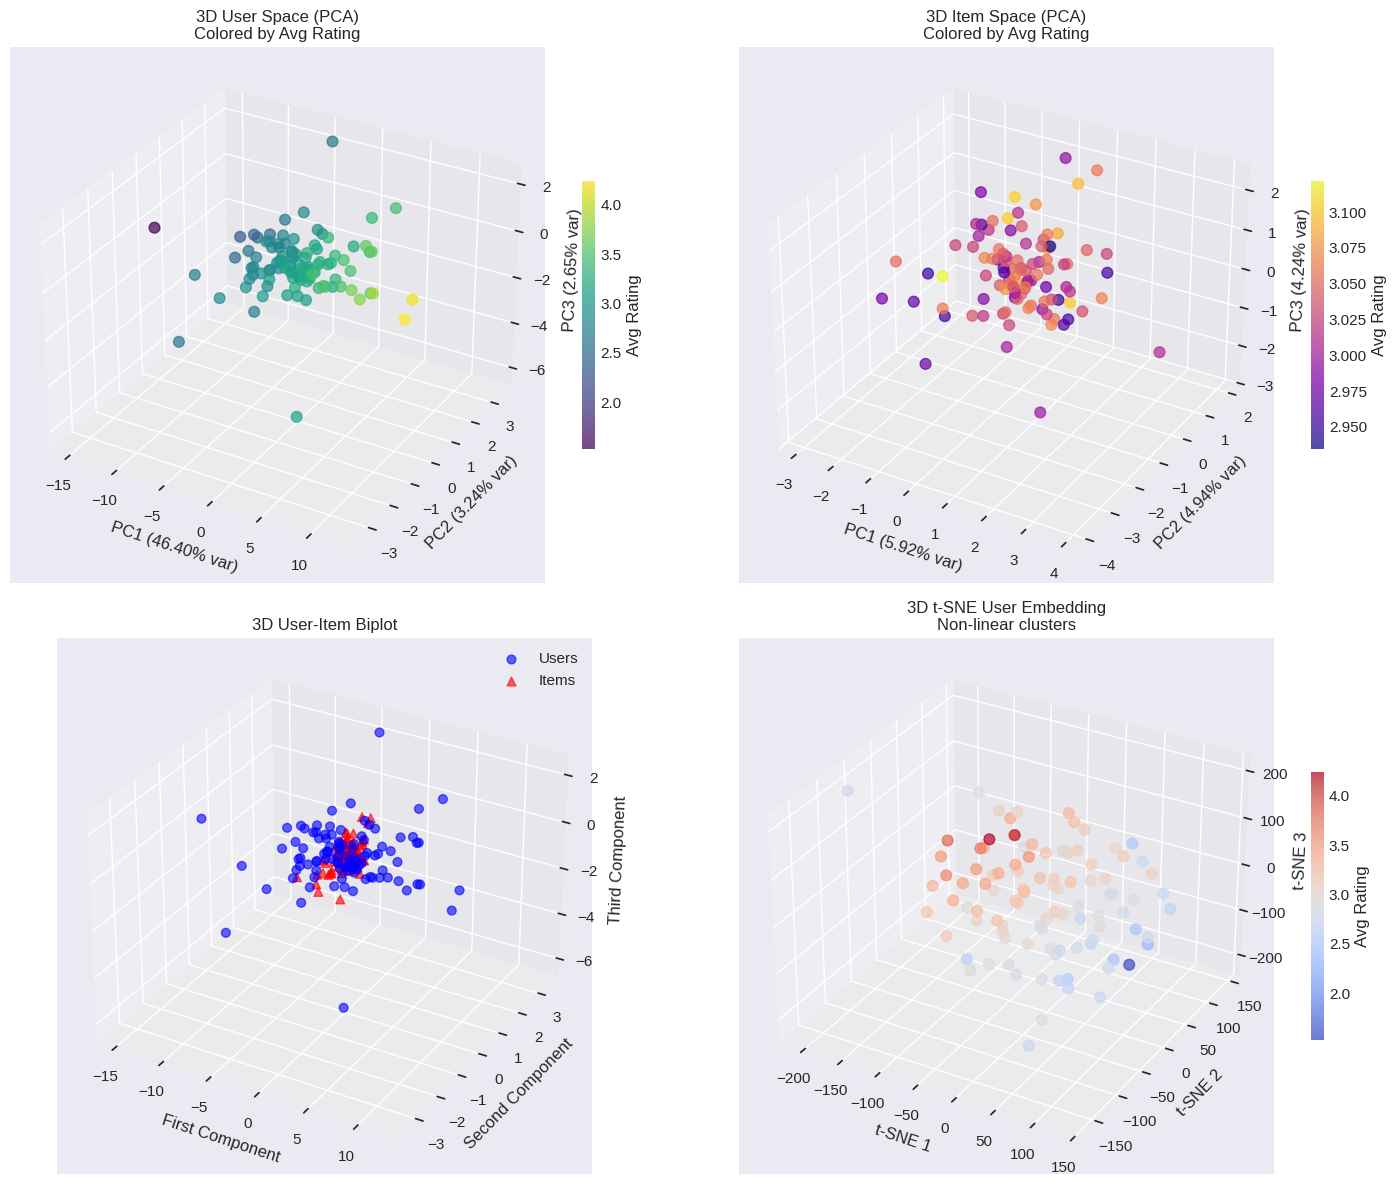

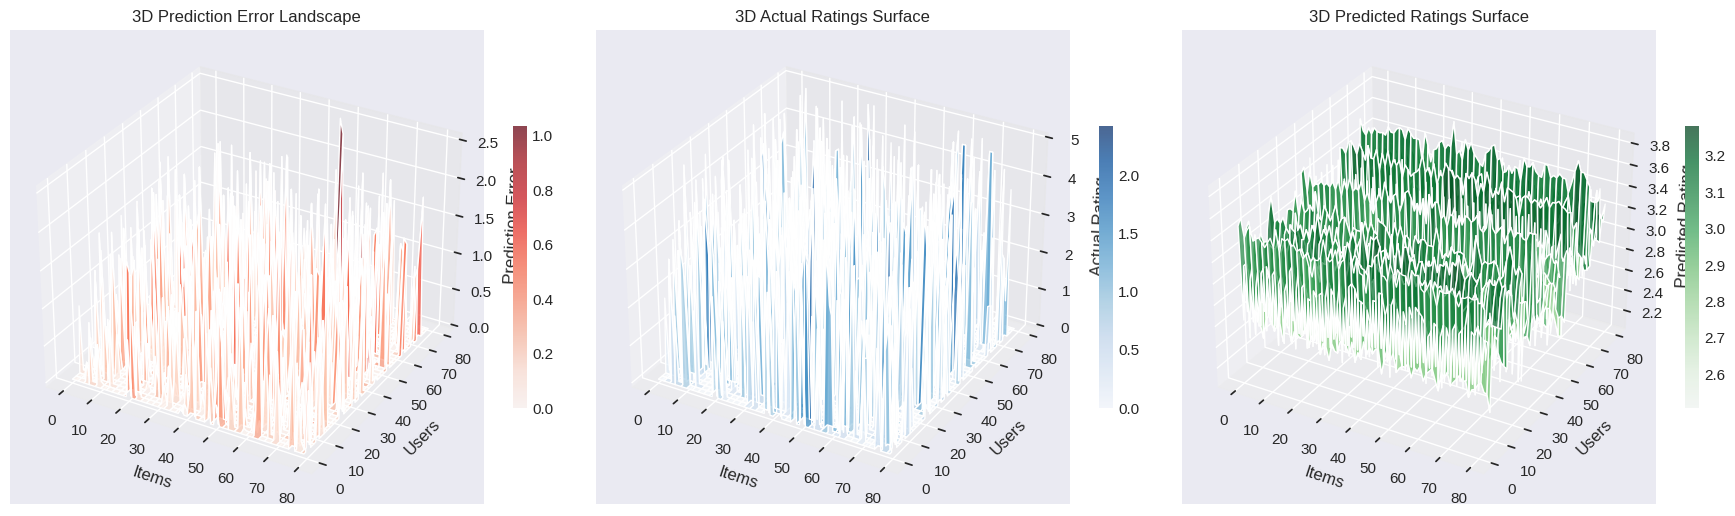

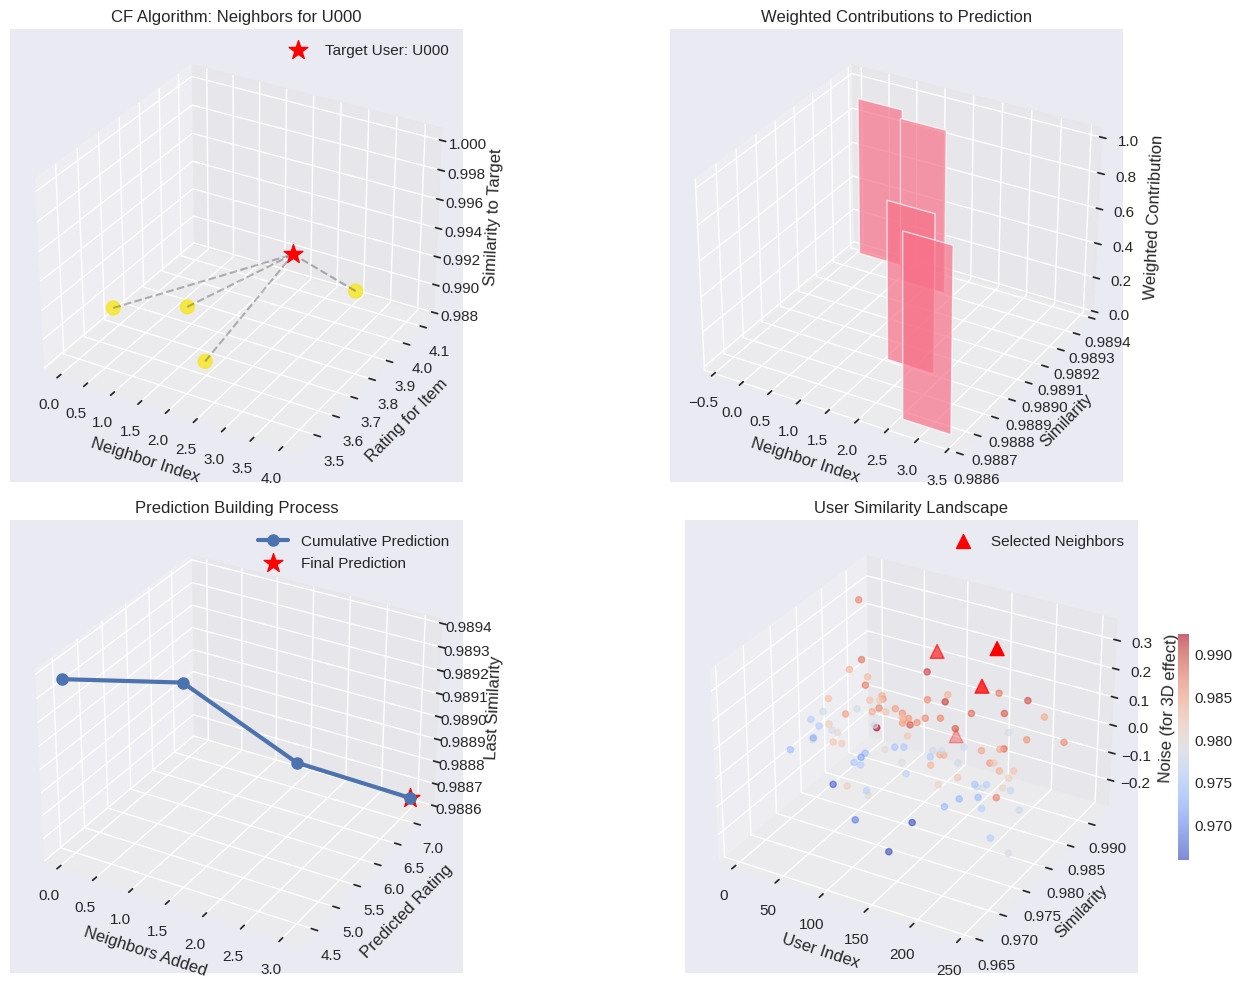


🎯 Prediction for U000 on M001:
   User mean rating: 3.46
   Neighbors used: 4
   Weighted sum: 15.00
   Similarity sum: 3.96
   Final prediction: 7.25
🎬 Running 3D Collaborative Filtering Visualizations...
1. Creating 3D User-Item Rating Space...


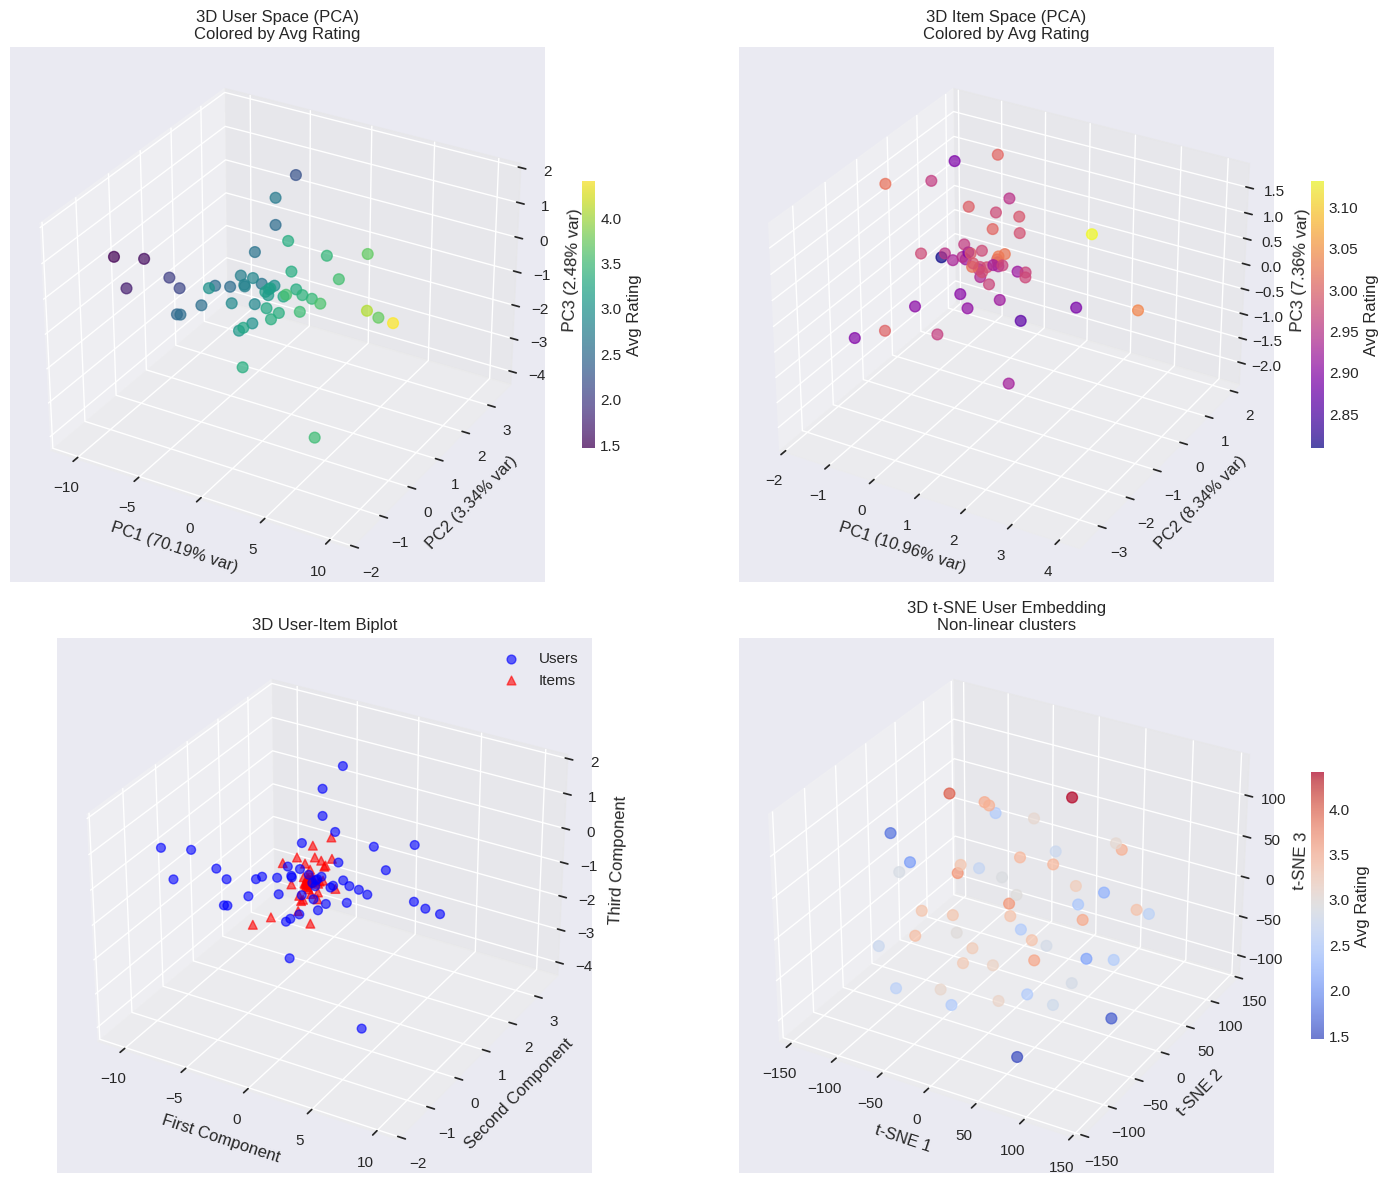

   PCA explained variance: [0.70188181 0.03343846 0.02482806]

2. Creating Interactive 3D Similarity Network...


   Network nodes: 80, edges: 3160

3. Creating 3D Prediction Landscape...


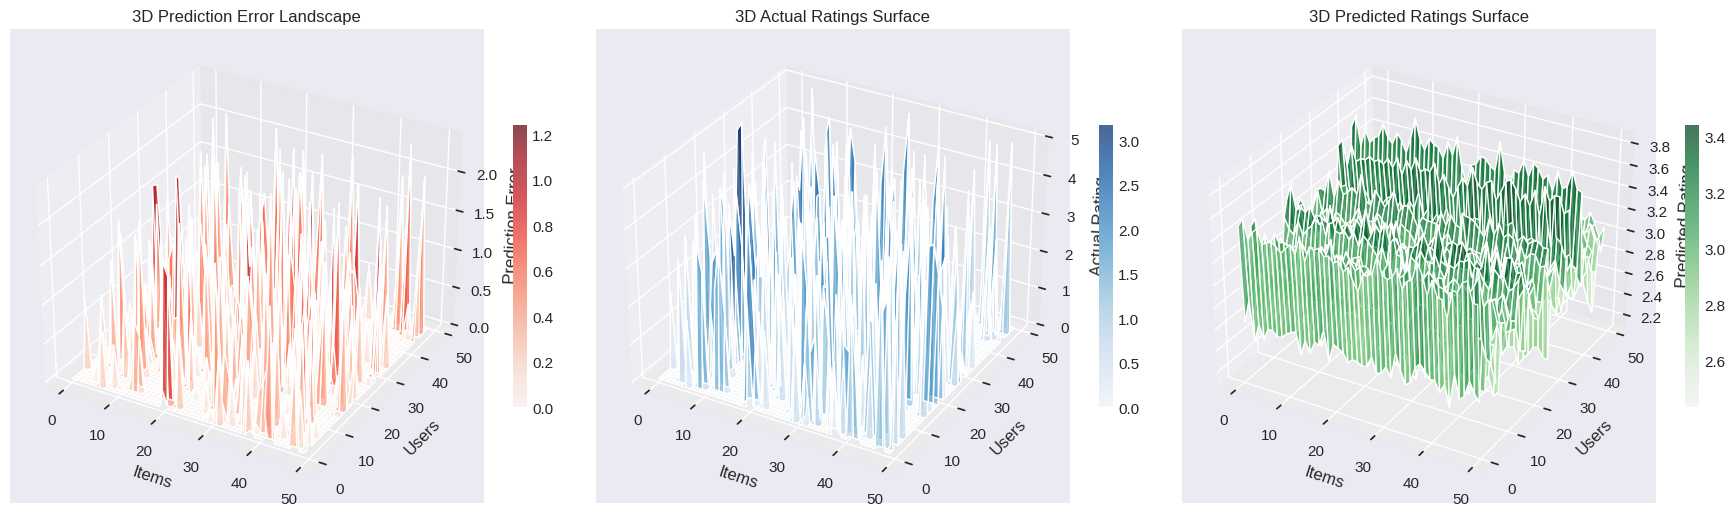


4. Creating Interactive Rating Distribution...



5. Visualizing CF Algorithm...


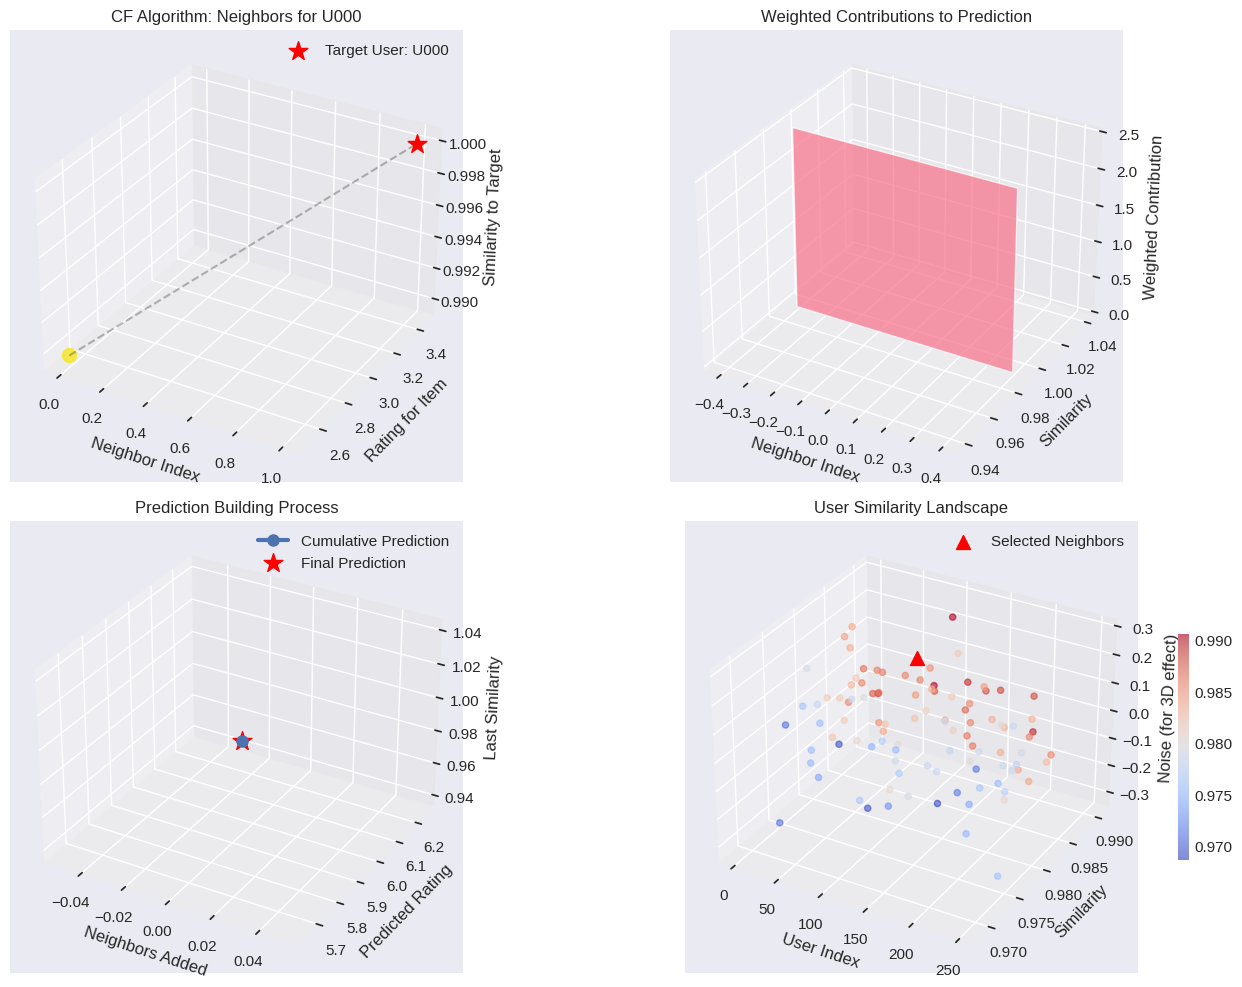


🎯 Prediction for U000 on M020:
   User mean rating: 3.46
   Neighbors used: 1
   Weighted sum: 2.47
   Similarity sum: 0.99
   Final prediction: 5.95

🎉 All 3D visualizations complete!


In [16]:
# Example usage string to add to notebook:

# After computing R, S, and R_pred in your notebook, run:

# Single visualizations:
plot_3d_rating_space(R, sample_users=100, sample_items=100)
create_interactive_similarity_network(S, threshold=0.75, sample_size=120)
plot_3d_prediction_landscape(R, R_pred, sample_users=80, sample_items=80)
create_interactive_rating_distribution(R)
visualize_cf_algorithm_3d(R, S, 'U000', 'M001', k=15)

# Or run all at once:
run_all_cf_visualizations(R, S, R_pred)
